In [22]:
# импорт пакета
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math


import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

matplotlib.rcParams['figure.figsize'] = (12,8)

import seaborn as sns

pd.options.mode.chained_assignment = None

# чтение данных
df_trans = pd.read_csv(r'F:\0Pytonchick\KursovayaAI\trans.csv', delimiter=';', low_memory=False)  # The transactions.
df_trans.info()
df_trans.head(8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   trans_id    1056320 non-null  int64  
 1   account_id  1056320 non-null  int64  
 2   date        1056320 non-null  int64  
 3   type        1056320 non-null  object 
 4   operation   873206 non-null   object 
 5   amount      1056320 non-null  float64
 6   balance     1056320 non-null  float64
 7   k_symbol    574439 non-null   object 
 8   bank        273508 non-null   object 
 9   account     295389 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 80.6+ MB


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN
5,771035,2632,930102,PRIJEM,VKLAD,1100.0,1100.0,NaN,NaN,NaN
6,452728,1539,930103,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
7,725751,2484,930103,PRIJEM,VKLAD,1100.0,1100.0,NaN,NaN,NaN


In [23]:
# filter for features
df_trans = df_trans[['date', 'account_id', 'type', 'amount']]

# Convert the date into date format.
df_trans['date'] = pd.to_datetime(df_trans['date'], format='%y%m%d')

df_trans.head(8)

,date,account_id,type,amount
0,1993-01-01,2378,PRIJEM,700.0
1,1993-01-01,576,PRIJEM,900.0
2,1993-01-01,704,PRIJEM,1000.0
3,1993-01-01,3818,PRIJEM,600.0
4,1993-01-02,1972,PRIJEM,400.0
5,1993-01-02,2632,PRIJEM,1100.0
6,1993-01-03,1539,PRIJEM,600.0
7,1993-01-03,2484,PRIJEM,1100.0


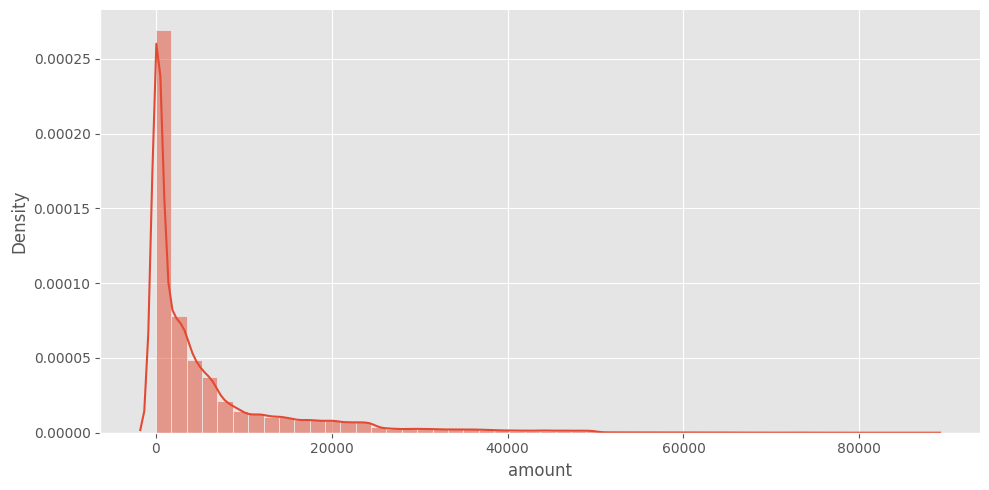

In [24]:
sns.displot(df_trans['amount'], bins=50, kde=True,stat="density", kde_kws=dict(cut=3),aspect=2)


<AxesSubplot:xlabel='type', ylabel='count'>

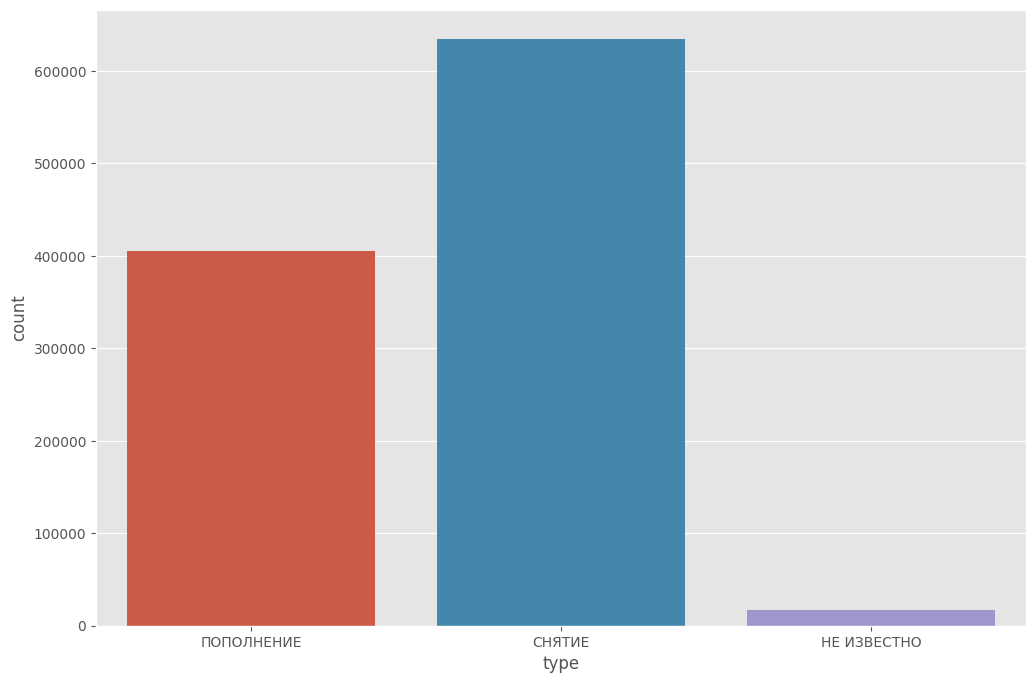

In [25]:
# Change the transaction types to English.
to_replace = {'PRIJEM': 'ПОПОЛНЕНИЕ', 'VYDAJ': 'СНЯТИЕ', 'VYBER': 'НЕ ИЗВЕСТНО'}
df_trans['type'] = df_trans['type'].replace(to_replace)
sns.countplot(x='type', data=df_trans)

In [26]:
#set the index to date because it’s required by time series functions in the Pandas package
df_withdrawals = df_trans.query('type == "СНЯТИЕ"').sort_values(by=['account_id', 'date']).set_index('date')
df_withdrawals.head(8)

,account_id,type,amount
date,,,
1995-06-22,1,СНЯТИЕ,200.0
1995-07-22,1,СНЯТИЕ,5300.0
1995-08-21,1,СНЯТИЕ,7500.0
1995-08-31,1,СНЯТИЕ,14.6
1995-09-05,1,СНЯТИЕ,2452.0
1995-09-20,1,СНЯТИЕ,700.0
1995-09-30,1,СНЯТИЕ,14.6
1995-10-05,1,СНЯТИЕ,2452.0


In [27]:

# получить сумму транзакций за последние 5 дней
df_withdrawals['sum_5days'] = df_withdrawals.groupby('account_id')['amount'].transform(lambda s: s.rolling(timedelta(days=5)).sum())

# получить количество транзакций за последние 5 дней
df_withdrawals['count_5days'] = df_withdrawals.groupby('account_id')['amount'].transform(lambda s: s.rolling(timedelta(days=5)).count())

df_withdrawals.head(20)

,account_id,type,amount,sum_5days,count_5days
date,,,,,
1995-06-22,1,СНЯТИЕ,200.0,200.0,1.0
1995-07-22,1,СНЯТИЕ,5300.0,5300.0,1.0
1995-08-21,1,СНЯТИЕ,7500.0,7500.0,1.0
1995-08-31,1,СНЯТИЕ,14.6,14.6,1.0
1995-09-05,1,СНЯТИЕ,2452.0,2452.0,1.0
1995-09-20,1,СНЯТИЕ,700.0,700.0,1.0
1995-09-30,1,СНЯТИЕ,14.6,14.6,1.0
1995-10-05,1,СНЯТИЕ,2452.0,2452.0,1.0
1995-10-20,1,СНЯТИЕ,2900.0,2900.0,1.0


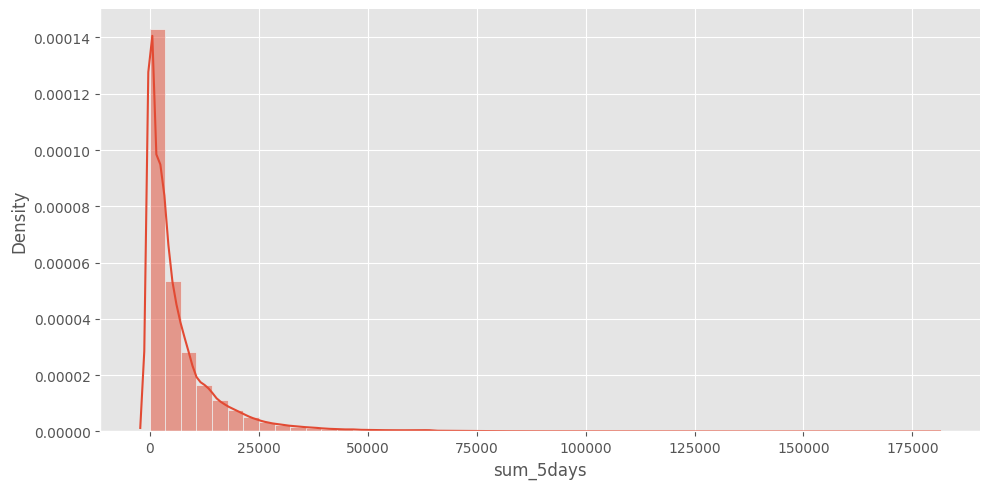

In [28]:
sns.displot(df_withdrawals['sum_5days'], bins=50, kde=True,stat="density", kde_kws=dict(cut=3),aspect=2)

<AxesSubplot:xlabel='count_5days', ylabel='count'>

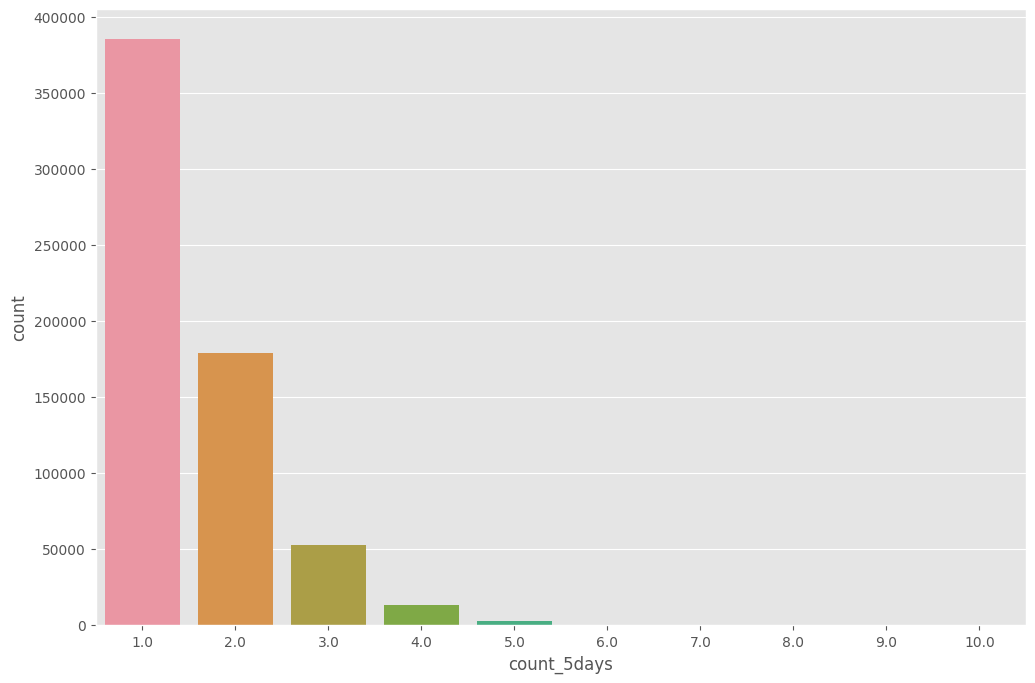

In [29]:
sns.countplot(x='count_5days', data=df_withdrawals)

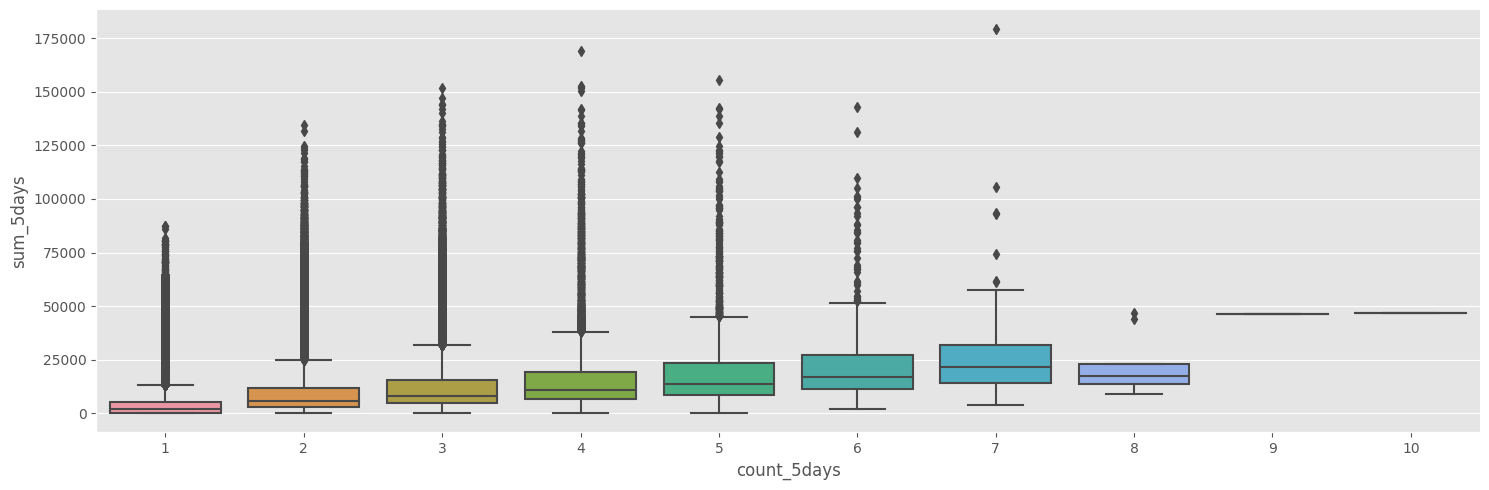

In [30]:
sns.catplot(x="count_5days", y="sum_5days",kind="box", data=df_withdrawals, order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],aspect=3.0)

In [39]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
# train model to detect outliers with splitting the data into train and test sets with anomaly proportion = 0.001.
X = df_withdrawals[['sum_5days', 'count_5days']].values
X_train,X_test = train_test_split(X, test_size=0.3, random_state=42)
clf = IsolationForest(random_state=0,contamination=0.001)
clf.fit(X_train)

IsolationForest(contamination=0.001, random_state=0)

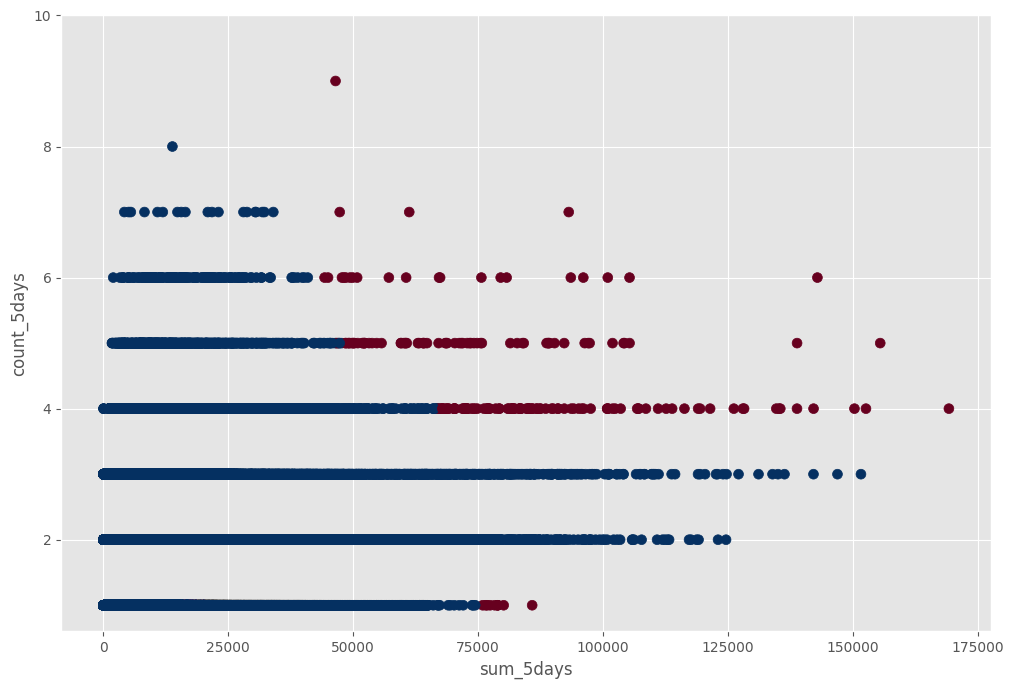

In [41]:
y_pred_test = clf.predict(X_test)

# plot the red outliners and blue inliners in the test set.
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test, s=50, cmap='RdBu')
plt.xlabel('sum_5days')
plt.ylabel('count_5days')
plt.ylim(ymax = 10)
plt.show()


In [32]:
# show the outliners in df_withdrawals dataframe with count_5days > 7.
df_withdrawals['outlier'] = clf.predict(df_withdrawals[['sum_5days', 'count_5days']])
df_withdrawals.query('outlier == -1 and count_5days > 7')


c:\Users\nicki\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,account_id,type,amount,sum_5days,count_5days,outlier
date,,,,,,
1996-01-14,635,СНЯТИЕ,2707.0,46637.0,8.0,-1
1997-01-11,7594,СНЯТИЕ,8700.0,44147.0,8.0,-1
1997-01-12,7594,СНЯТИЕ,2302.0,46449.0,9.0,-1
1997-01-12,7594,СНЯТИЕ,210.0,46659.0,10.0,-1


In [33]:
df_withdrawals.query('outlier == -1 and account_id == 816')

,account_id,type,amount,sum_5days,count_5days,outlier
date,,,,,,
1998-01-11,816,СНЯТИЕ,15900.0,64414.0,5.0,-1
1998-01-14,816,СНЯТИЕ,4200.0,64100.0,5.0,-1


In [34]:
df_withdrawals.query('outlier == 1 and account_id == 1')

,account_id,type,amount,sum_5days,count_5days,outlier
date,,,,,,
1995-06-22,1,СНЯТИЕ,200.0,200.0,1.0,1
1995-07-22,1,СНЯТИЕ,5300.0,5300.0,1.0,1
1995-08-21,1,СНЯТИЕ,7500.0,7500.0,1.0,1
1995-08-31,1,СНЯТИЕ,14.6,14.6,1.0,1
1995-09-05,1,СНЯТИЕ,2452.0,2452.0,1.0,1
...,...,...,...,...,...,...
1998-11-05,1,СНЯТИЕ,2452.0,2452.0,1.0,1
1998-11-14,1,СНЯТИЕ,510.0,510.0,1.0,1
1998-11-30,1,СНЯТИЕ,14.6,14.6,1.0,1
